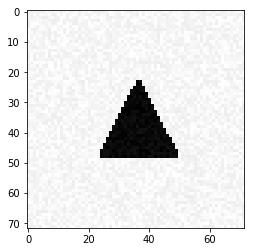

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# Part 3 Simple classification

In [361]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# We create the dataaset
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### Stochastic gradient optimizer

In [375]:
# We compute our first model with a stochastic gradient optimizer
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.compile(optimizer=optimizers.SGD(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, utils.to_categorical(Y_train), epochs=100, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 2s 9ms/step - loss: 5.1203 - acc: 0.3370 - val_loss: 4.0267 - val_acc: 0.2333
Epoch 2/100
270/270 [==============================] - 0s 75us/step - loss: 3.8524 - acc: 0.3815 - val_loss: 3.8943 - val_acc: 0.6000
Epoch 3/100
270/270 [==============================] - 0s 68us/step - loss: 4.3327 - acc: 0.3667 - val_loss: 3.8887 - val_acc: 0.7333
Epoch 4/100
270/270 [==============================] - 0s 73us/step - loss: 2.4782 - acc: 0.5667 - val_loss: 2.7672 - val_acc: 0.6333
Epoch 5/100
270/270 [==============================] - 0s 71us/step - loss: 2.8802 - acc: 0.5148 - val_loss: 0.8660 - val_acc: 0.7333
Epoch 6/100
270/270 [==============================] - 0s 68us/step - loss: 1.7444 - acc: 0.5630 - val_loss: 0.2380 - val_acc: 0.9000
Epoch 7/100
270/270 [==============================] - 0s 72us/step - loss: 1.4831 - acc: 0.6556 - val_loss: 2.5679 - val_acc: 0.7333
Epoch 8/100
270/27

270/270 [==============================] - 0s 64us/step - loss: 0.0717 - acc: 0.9963 - val_loss: 0.0610 - val_acc: 0.9667
Epoch 62/100
270/270 [==============================] - 0s 70us/step - loss: 0.0627 - acc: 0.9963 - val_loss: 0.0550 - val_acc: 1.0000
Epoch 63/100
270/270 [==============================] - 0s 62us/step - loss: 0.0916 - acc: 0.9704 - val_loss: 0.0939 - val_acc: 0.9667
Epoch 64/100
270/270 [==============================] - 0s 63us/step - loss: 0.0854 - acc: 0.9667 - val_loss: 0.0615 - val_acc: 1.0000
Epoch 65/100
270/270 [==============================] - 0s 61us/step - loss: 0.0930 - acc: 0.9778 - val_loss: 0.1315 - val_acc: 0.9333
Epoch 66/100
270/270 [==============================] - 0s 60us/step - loss: 0.1007 - acc: 0.9630 - val_loss: 0.0842 - val_acc: 0.9667
Epoch 67/100
270/270 [==============================] - 0s 58us/step - loss: 0.0642 - acc: 0.9852 - val_loss: 0.0551 - val_acc: 1.0000
Epoch 68/100
270/270 [==============================] - 0s 59us/step

From the teacher's code, category 0 is a rectangle, category 1 i a disk, and category 2 is a triangle. We check that our first model predicts well.

In [376]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [377]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [378]:
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

### Adam optimizer

In [380]:
# We compute our first model with the Adam optimizer
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, utils.to_categorical(Y_train), epochs=30, validation_split=0.1, batch_size = 32)

Train on 270 samples, validate on 30 samples
Epoch 1/30
270/270 [==============================] - 3s 9ms/step - loss: 1.6832 - acc: 0.4148 - val_loss: 1.0229 - val_acc: 0.4333
Epoch 2/30
270/270 [==============================] - 0s 72us/step - loss: 0.7953 - acc: 0.6407 - val_loss: 1.2879 - val_acc: 0.2667
Epoch 3/30
270/270 [==============================] - 0s 72us/step - loss: 0.6537 - acc: 0.6963 - val_loss: 0.4044 - val_acc: 0.9333
Epoch 4/30
270/270 [==============================] - 0s 70us/step - loss: 0.4751 - acc: 0.8148 - val_loss: 0.2853 - val_acc: 0.9333
Epoch 5/30
270/270 [==============================] - 0s 67us/step - loss: 0.3808 - acc: 0.8630 - val_loss: 0.2401 - val_acc: 0.9667
Epoch 6/30
270/270 [==============================] - 0s 66us/step - loss: 0.2874 - acc: 0.9667 - val_loss: 0.2040 - val_acc: 0.9667
Epoch 7/30
270/270 [==============================] - 0s 69us/step - loss: 0.2522 - acc: 0.9667 - val_loss: 0.2343 - val_acc: 0.8667
Epoch 8/30
270/270 [=====

In [381]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [382]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [383]:
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

### Comments on the results

Both optimizer work very well for this problem, and are able to classify the shapes. Adam seems better that the stochastic gradient though. 
Indeed, I don't have to parametrize it to make it work. And it seems more accurate and requires less epochs to converge (even though that might be because my hyperparameters of SGD are not that good).

# Part 4 Visualization of the solution

In [388]:
weights = model.get_weights()[0]

### Column 0

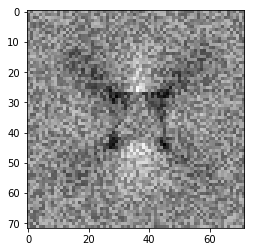

In [390]:
plt.imshow(weights[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Column 1

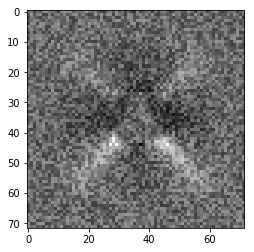

In [391]:
plt.imshow(weights[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Column 2

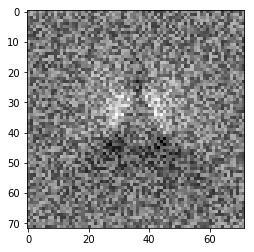

In [392]:
plt.imshow(weights[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

### Comments on the results

The 3 columns correspont to our 3 classes. We can see that our network detects a rectangle by finding its corners (hence the black area around the corners), detects a circle by not finding corners (hence the white areas where the corners should be), and detects a triangle by not finding colored pixels at the top of the image, but by finding some on its bottom).

# Part 5 A More Difficult Classification Problem